# Test zero-shot recognition with CLIP

In [1]:
cd ..

/home/p300488/cognitive_robotics_LLM_planning/cognitive_robotics_LLM_based_manipulation


In [2]:
from clip_utils import ClipInference, display_image

CLIP = ClipInference()

Setup a scene in Pybullet

In [3]:
from env.env import *
from env.camera import Camera
from env.objects import YcbObjects

# load camera and env
center_x, center_y, center_z = CAM_X, CAM_Y, CAM_Z
camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (IMG_SIZE, IMG_SIZE), 40)
env = Environment(camera, vis=True, asset_root='./env/assets', debug=False, finger_length=0.06)

# load objects
objects = YcbObjects('./env/assets/ycb_objects',
                    mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                    mod_stiffness=['Strawberry'],
                    seed=22
)
objects.shuffle_objects()

n_objects = 5

for obj_name in objects.obj_names[:n_objects]:
    path, mod_orn, mod_stiffness = objects.get_obj_info(obj_name)
    env.load_isolated_obj(path, obj_name, mod_orn, mod_stiffness)
env.dummy_simulation_steps(10)

pybullet build time: Nov 28 2023 23:51:11


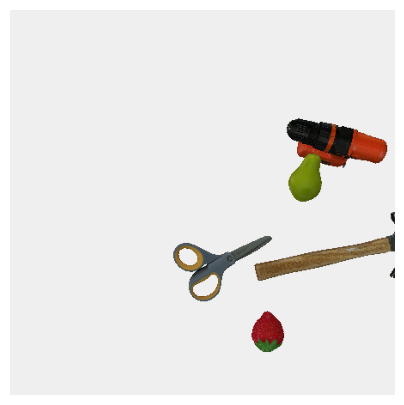

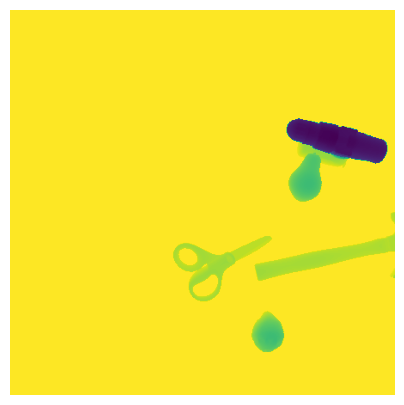

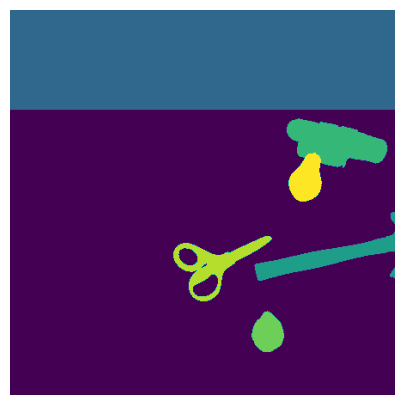

In [4]:
# visualize sensors
image, depth, seg = env.camera.get_cam_img()
display_image(image, size=(5,5))
display_image(depth, size=(5,5))
display_image(seg, size=(5,5))

### Use CLIP as zero-shot recognizer (match objects to language)

Here you can define a list of all YCB objects and make CLIP rank them according to segmented objects from the scene image. This will compare the CLIP visual embedding of each object (after it has been segmented) with the CLIP text embeddings of each category. The most similar category will be returned as the object category label. This functionality is ensured by passing `mode="object"` when calling CLIP.

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3060 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 525.147.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 525.147.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3060 Ti/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: No inertial data for link

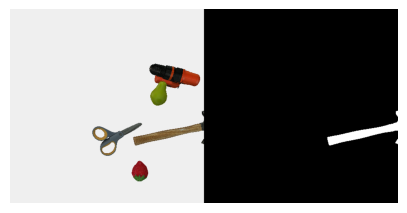

power drill 7


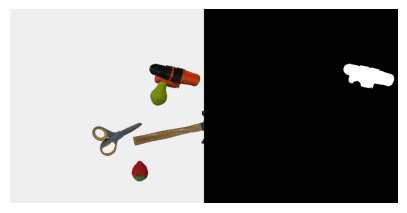

strawberry 8


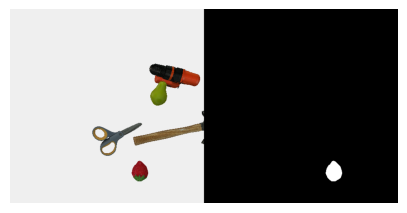

scissors 9


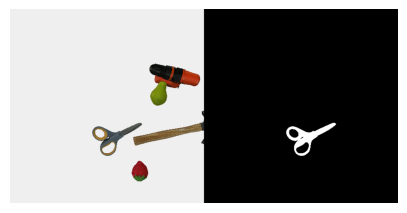

pear 10


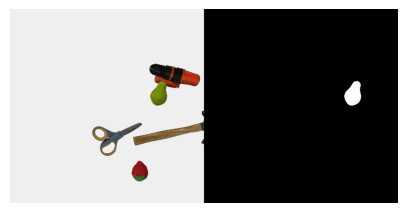

In [5]:
# define YCB objects
all_ycb_categories = [
    "banana",
    "chips can",
    "cracker box",
    "foam brick",
    "gelatin box",
    "hammer",
    "master chef can",
    "medium clamp",
    "mustard bottle",
    "pear",
    "potted meat can",
    "power drill",
    "scissors",
    "strawberry",
    "tennis ball",
    "tomato soup can"
]

category_name_str = ";".join(all_ycb_categories) # CLIP queries must separate categories by ; using a single string

clip_predictions = CLIP.get_most_similar(image, seg, category_name_str, mode="object", prompt_engineering=False, this_is=False, show=True)

In [6]:
print(clip_predictions[0].keys())

dict_keys(['mask', 'category', 'objID'])


For each object, this function returns its mask in RGB frame `mask`, the predicted `category` by CLIP, as well as its Pybullet unique ID in `objID`.

### Use CLIP as open-vocabulary grounder (match language to objects)

This is the reverse process as above, which is ensured by giving `mode="query"`. You can define *any* arbitrary language query to search for an object, or even multiple queries, and CLIP will compare similarities between each one of them and the segmented object masks. The most similar object per query will be returned.

red electrical tool 7


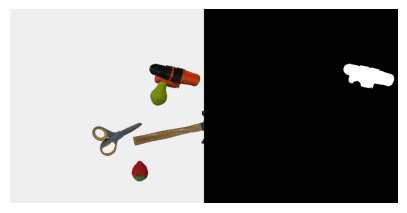

green fruit 10


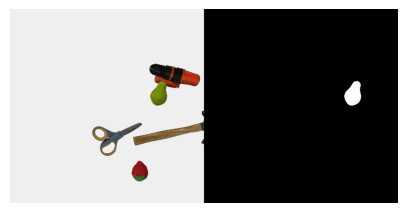

small red fruit 8


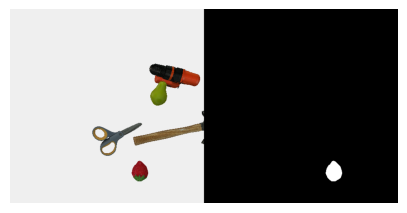

wooden tool 6


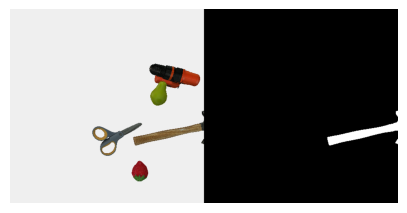

tool to cut things 9


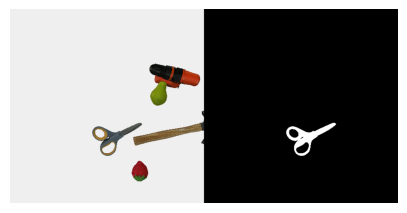

In [7]:
# define any language query
open_vocab_queries = [
    "red electrical tool",
    "green fruit",
    "small red fruit",
    "wooden tool",
    "tool to cut things",
]

queries_str = ";".join(open_vocab_queries) # CLIP queries must separate categories by ; using a single string

clip_predictions = CLIP.get_most_similar(image, seg, queries_str, mode="query", prompt_engineering=False, this_is=False, show=True)

In [8]:
print(clip_predictions[0].keys())

dict_keys(['mask', 'prompt', 'objID'])


For each query prompt, this function returns the predicted object's `mask`, as well as its Pybullet unique ID in `objID`.


After you get the desired object mask, you can pass it to GR-ConvNet for grasping (see other example notebooks).

### Issues

If you play around with multiple different objects and scene configurations, you will see that CLIP is not always correct. There are several reasons for this, mention a few here:

1) CLIP has been trained on image-text caption pairs from the Web and hence text captions are noisy and not refer to particular scene objects. Prompt engineering has been researched for making CLIP work well in the recognition setting. You can play around with the `prompt_engineering` and `this_is` arguments to see if CLIP works better. The first will utilize multiple query templates besides just the category name (e.g. "This is a picture of a __", "A blurry photo of a _"). Currently, the ImageNet templates from previous works are used. Feel free to mess around with prompt templates in `clip_utils.py` to see if you can increase performance. `this_is` will just add "this is" as a prefix in the prompt. Use with `show=False` to avoid visualizations.
    
2) The top-down camera view results in sometimes viewing only a small surface of the object, which is not enough for CLIP to recognize it. For example, if a can is spawned sitting upright in the table, the top-down camera view can only see its silver cap and CLIP cannot tell if its a meat can, tomato soup can etc. as no texture information are visible. You can alleviate this by either:
   
   - Add a second camera to provide a better viewpoint of the scene. Use that camera image for CLIP, while the top-down camera image for Gr-ConvNet. This would require modifying the `env.camera` and `env.env` scripts in this repo, 

   - Modify the code in `env.objects` to make sure that such objects such as cans are never spawned upright, so their texture is always visible from topdown view.

In [26]:
# close client
p.disconnect()

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
